# 正弦函数の13次多項式による近似

区間 $[-\pi/4, \pi/4]$ で $\sin x$ を効率よく近似する13次多項式 $F_{13}(x)$ を計算する. 以下で $F_{10}(x)$ は10次多項式.

* `Remez_abs`: $\sin(x) - F_{13}(x)$ のsupノルムを最小化
* `Remez_rel`: $\dfrac{\sin(x) - F_{13}(x)}{\sin(x)}$ のsupノルムを最小化)
* `Remez_rel1`: $\dfrac{\sin(x) - x - x^3 F_{10}(x)}{\sin(x)}$ のsupノルムを最小化)
* `Remez_rel2`: $\dfrac{\sin(x) - x - x^3 F_{10}(x)}{x}$ のsupノルムを最小化)

最後の `Remez_rel2` の場合の $x + x^3 F_{10}(x)$ が [Julia の trig.jl](https://github.com/JuliaLang/julia/blob/master/base/special/trig.jl#L54) で使われている13次多項式に非常に近い.

さらに, 低次の係数からFloat64での値に順次固定して求めて行くと, さらに近くなる.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Remez.jlの使用例" data-toc-modified-id="Remez.jlの使用例-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Remez.jlの使用例</a></span></li><li><span><a href="#低次の係数からFloat64での値に順次固定して求めてみる" data-toc-modified-id="低次の係数からFloat64での値に順次固定して求めてみる-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>低次の係数からFloat64での値に順次固定して求めてみる</a></span><ul class="toc-item"><li><span><a href="#weight-1/x-(minimaximize-the-pseudo-relative-error)" data-toc-modified-id="weight-1/x-(minimaximize-the-pseudo-relative-error)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>weight 1/x (minimaximize the pseudo relative error)</a></span></li><li><span><a href="#weight-1/sin(x)-(minimaximize-the-exact-relative-error)" data-toc-modified-id="weight-1/sin(x)-(minimaximize-the-exact-relative-error)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>weight 1/sin(x) (minimaximize the exact relative error)</a></span></li></ul></li><li><span><a href="#以下は汚い試行錯誤の残骸" data-toc-modified-id="以下は汚い試行錯誤の残骸-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>以下は汚い試行錯誤の残骸</a></span></li></ul></div>

https://github.com/simonbyrne/Remez.jl

In [1]:
using Remez
using Quadmath
using Polynomials
using Plots

relerr(x, y) = iszero(x - y) ? x - y : (x - y)/y 

relerr (generic function with 1 method)

In [2]:
?ratfn_minimax

search: ratfn_minimax



```
N,D,E,X = ratfn_minimax(f, interval, n, d, w)
```

Top-level function to find a minimax rational-function approximation.

Arguments:

  * f         The function to be approximated. Maps BigFloat -> BigFloat.
  * interval  A tuple giving the endpoints of the interval           (in either order) on which to approximate f.
  * n, d      The degrees of the numerator and denominator of the desired           approximation.
  * w         Error-weighting function. Takes two BigFloat arguments x,y           and returns a scaling factor for the error at that location.           The returned approximation R should have the minimum possible           maximum value of abs((f(x)-R(x)) * w(x,f(x))). Optional           parameter, defaulting to the always-return-1 function.

Return values: a tuple (N,D,E,X), where

  * N,D       A pair of arrays of BigFloats giving the coefficients           of the returned rational function. N has size n+1; D           has size d+1. Both start with the constant term, i.e.           N[i] is the coefficient of x^(i-1) (because Julia           arrays are 1-based). D[1] will be 1.
  * E         The maximum weighted error (BigFloat).
  * X         An array of pairs of BigFloats giving the locations of n+2           points and the weighted error at each of those points. The           weighted error values will have alternating signs, which           means that the Chebyshev alternation theorem guarantees           that any other function of the same degree must exceed           the error of this one at at least one of those points.


## Remez.jlの使用例

In [3]:
@time N0, D0, E0, X0 = ratfn_minimax(sin, (-big(π)/4, big(π)/4), 13, 0)
sleep(0.1)
c0 = @. Float128(round(N0; digits=50))
c0[begin+1:2:end] |> display
sin_Remez_abs = Polynomial(c0)

7-element Vector{Float128}:
  9.99999999999999976432750809261703522e-01
 -1.66666666666665239879623895564201292e-01
  8.33333333330834420236141769346427279e-03
 -1.98412698219708601849981943853856262e-04
  2.75573115717991056132706292662582729e-06
 -2.50504829456534532749195653744669101e-08
  1.58830635423927591680356864963272916e-10

  0.220585 seconds (1.60 M allocations: 84.746 MiB, 4.21% gc time, 22.42% compilation time)


Polynomial(9.99999999999999976432750809261703522e-01*x - 1.66666666666665239879623895564201292e-01*x^3 + 8.33333333330834420236141769346427279e-03*x^5 - 1.98412698219708601849981943853856262e-04*x^7 + 2.75573115717991056132706292662582729e-06*x^9 - 2.50504829456534532749195653744669101e-08*x^11 + 1.58830635423927591680356864963272916e-10*x^13)

In [4]:
function chebyshev_approx(d, F::Polynomial{CT}) where CT
    P = F
    for k in degree(F):-1:d+1
        degree(P) < k && continue
        a = coeffs(P)[end]
        T = ChebyshevT([zeros(CT, k); a/CT(2)^(k-1)])
        P = P - T
    end
    P
end

function maclaurin_sinpio4(d, CT=BigFloat)
    s = [isodd(k) ? (-1)^((k-1)÷2)*(big(π)/4)^k/factorial(CT(k)) : zero(CT) for k in 0:d]
    Polynomial(s)
end

function maclaurin_sin(d, CT=BigFloat)
    s = [isodd(k) ? (-1)^((k-1)÷2)/factorial(CT(k)) : zero(CT) for k in 0:d]
    Polynomial(s)
end

function ordinaryscale(F::Polynomial{CT}) where CT
    c = coeffs(F) ./ [(CT(π)/4)^k for k in 0:degree(F)]
    Polynomial(c)
end

S1 = chebyshev_approx(13, maclaurin_sinpio4(61)) |> ordinaryscale
S2 = chebyshev_approx(13, maclaurin_sinpio4(63)) |> ordinaryscale
S3 = chebyshev_approx(13, maclaurin_sinpio4(65)) |> ordinaryscale
@show [
    S1 - S2
    S2 - S3
]
sleep(0.1)

s = Float128.(coeffs(S2))
s[begin+1:2:end] |> display
sin_genkuroki_abs = Polynomial(s)

7-element Vector{Float128}:
  9.99999999999999976421161200972558865e-01
 -1.66666666666665239353534874772699860e-01
  8.33333333330833737931037048493639536e-03
 -1.98412698219670677409549675909503745e-04
  2.75573115707744123859880350508182971e-06
 -2.50504828127584197162086832721345671e-08
  1.58830569133699770601832491512218047e-10

[S1 - S2; S2 - S3] = Polynomial{BigFloat, :x}[Polynomial(-2.010764683385948796148028192762378503362648273919774541869690518399838312334015e-87*x^13), Polynomial(0.0)]


Polynomial(9.99999999999999976421161200972558865e-01*x - 1.66666666666665239353534874772699860e-01*x^3 + 8.33333333330833737931037048493639536e-03*x^5 - 1.98412698219670677409549675909503745e-04*x^7 + 2.75573115707744123859880350508182971e-06*x^9 - 2.50504828127584197162086832721345671e-08*x^11 + 1.58830569133699770601832491512218047e-10*x^13)

In [5]:
coeffs(sin_genkuroki_abs - sin_Remez_abs)[begin+1:2:end]

7-element Vector{Float128}:
 -1.15896082891446568525761630041555508e-20
  5.26089020791501431641401407789796842e-19
 -6.82305104720852787742638798856571736e-18
  3.79244404322679443525171710674295407e-17
 -1.02469322728259421543997579542500915e-16
  1.32895033558710882102332342966324990e-16
 -6.62902278210785243734510548685360483e-17

In [6]:
coeffs(sin_Remez_abs)[begin+1:2:end] .|> Float64

7-element Vector{Float64}:
  1.0
 -0.16666666666666524
  0.008333333333308345
 -0.0001984126982197086
  2.7557311571799106e-6
 -2.5050482945653454e-8
  1.588306354239276e-10

In [7]:
@time N1, D1, E1, X1 = ratfn_minimax(sin, (-big(π)/4, big(π)/4), 13, 0, (x,y)->1/(eps(BigFloat)+abs(y)))
sleep(0.1)
c1 = @. Float128(round(N1; digits=50))
c1[begin+1:2:end] |> display
sin_Remez_rel = Polynomial(c1)

7-element Vector{Float128}:
  9.99999999999999996687956622803898013e-01
 -1.66666666666666147536535449281876047e-01
  8.33333333332000244425256051662853206e-03
 -1.98412698284021299269825006228404938e-04
  2.75573132990150933369252192538385149e-06
 -2.50507058463844806495028316806542837e-08
  1.58941363722592400686760097949942827e-10

  0.764734 seconds (3.86 M allocations: 226.220 MiB, 5.10% gc time, 72.70% compilation time)


Polynomial(9.99999999999999996687956622803898013e-01*x - 1.66666666666666147536535449281876047e-01*x^3 + 8.33333333332000244425256051662853206e-03*x^5 - 1.98412698284021299269825006228404938e-04*x^7 + 2.75573132990150933369252192538385149e-06*x^9 - 2.50507058463844806495028316806542837e-08*x^11 + 1.58941363722592400686760097949942827e-10*x^13)

In [8]:
coeffs(sin_Remez_rel)[begin+1:2:end] .|> Float64

7-element Vector{Float64}:
  1.0
 -0.16666666666666616
  0.008333333333320002
 -0.0001984126982840213
  2.755731329901509e-6
 -2.505070584638448e-8
  1.589413637225924e-10

In [9]:
sinmxox3(x) = iszero(x) ? -1/big(6) : (sin(x) - x)/x^3 # sin(x) minus X over x^3
w_sinmxox3(x, y) = iszero(x) ? x : abs(x^3/sin(x))

@time N2, D2, E2, X2 = ratfn_minimax(sinmxox3, (-big(π)/4, big(π)/4), 10, 0, w_sinmxox3)
sleep(0.1)
c2 = @. Float128(round(N2; digits=50))
c2 = Float128[0; 1; 0; c2]
c2[begin+1:2:end] |> display
sin_Remez_rel1 = Polynomial(c2)

7-element Vector{Float128}:
  1.00000000000000000000000000000000000e+00
 -1.66666666666666307295231942470655646e-01
  8.33333333332211858862076734865529242e-03
 -1.98412698295895384658205433413002396e-04
  2.75573136213856773549013111146861934e-06
 -2.50507477628503540134642969471870803e-08
  1.58962301572218447952204692520516006e-10

  0.288843 seconds (1.80 M allocations: 96.118 MiB, 3.52% gc time)


Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666307295231942470655646e-01*x^3 + 8.33333333332211858862076734865529242e-03*x^5 - 1.98412698295895384658205433413002396e-04*x^7 + 2.75573136213856773549013111146861934e-06*x^9 - 2.50507477628503540134642969471870803e-08*x^11 + 1.58962301572218447952204692520516006e-10*x^13)

In [10]:
coeffs(sin_Remez_rel1)[begin+1:2:end] .|> Float64

7-element Vector{Float64}:
  1.0
 -0.1666666666666663
  0.008333333333322118
 -0.0001984126982958954
  2.7557313621385676e-6
 -2.5050747762850355e-8
  1.5896230157221844e-10

* https://github.com/JuliaLang/julia/blob/master/base/special/trig.jl#L54
* https://github.com/JuliaMath/openlibm/blob/master/src/k_sin.c#L51
* https://github.com/freebsd/freebsd-src/blob/main/lib/msun/src/k_sin.c#L50

In [11]:
DS0 =  1.0
DS1 = -1.66666666666666324348e-01
DS2 =  8.33333333332248946124e-03
DS3 = -1.98412698298579493134e-04
DS4 =  2.75573137070700676789e-06
DS5 = -2.50507602534068634195e-08
DS6 =  1.58969099521155010221e-10

sin_julia = Polynomial(Float128[0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6])

Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666324347900740576733369e-01*x^3 + 8.33333333332248946123677058039902477e-03*x^5 - 1.98412698298579493133911300084548657e-04*x^7 + 2.75573137070700676789039053338203900e-06*x^9 - 2.50507602534068634195381207073125007e-08*x^11 + 1.58969099521155010221126344989060405e-10*x^13)

In [12]:
coeffs(sin_Remez_rel1 - sin_julia)[begin+1:2:end]

7-element Vector{Float128}:
  0.00000000000000000000000000000000000e+00
  1.70526687981060777229530541141197664e-17
 -3.70872616003231743732349627681352211e-16
  2.68410847570586667154626107245525841e-15
 -8.56843903240025942191341966054237646e-15
  1.24905565094060738237601254204295829e-14
 -6.79794893656226892165246854439931974e-15

In [13]:
[0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6][begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.00833333333332249
 -0.0001984126982985795
  2.7557313707070068e-6
 -2.5050760253406863e-8
  1.58969099521155e-10

In [14]:
Float64.(coeffs(sin_Remez_rel1)[begin+1:2:end])

7-element Vector{Float64}:
  1.0
 -0.1666666666666663
  0.008333333333322118
 -0.0001984126982958954
  2.7557313621385676e-6
 -2.5050747762850355e-8
  1.5896230157221844e-10

In [15]:
(Float64[0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6] - 
    Float64.(coeffs(sin_Remez_rel1)))[begin+1:2:end]

7-element Vector{Float64}:
  0.0
 -2.7755575615628914e-17
  3.712308238590367e-16
 -2.684105108313739e-15
  8.568439181241101e-15
 -1.2490556508101958e-14
  6.79794893657204e-15

In [16]:
sinmxox3(x) = iszero(x) ? -1/big(6) : (sin(x) - x)/x^3 # sin(x) minus X over x^3

@time N3, D3, E3, X3 = ratfn_minimax(sinmxox3, (-big(π)/4, big(π)/4), 10, 0, (x,y)->x^2)
sleep(0.1)
c3 = @. Float128(round(N3; digits=50))
c3 = Float128[0; 1; 0; c3]
c3[begin+1:2:end] |> display
sin_Remez_rel2 = Polynomial(c3)

7-element Vector{Float128}:
  1.00000000000000000000000000000000000e+00
 -1.66666666666666320682100284734673128e-01
  8.33333333332242453061710164240838880e-03
 -1.98412698298169519982088571757731898e-04
  2.75573136952267715796435540350079496e-06
 -2.50507586532927947765459874988117098e-08
  1.58968279294470556731220197278242257e-10

  0.718073 seconds (3.10 M allocations: 190.398 MiB, 4.69% gc time, 75.82% compilation time)


Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666320682100284734673128e-01*x^3 + 8.33333333332242453061710164240838880e-03*x^5 - 1.98412698298169519982088571757731898e-04*x^7 + 2.75573136952267715796435540350079496e-06*x^9 - 2.50507586532927947765459874988117098e-08*x^11 + 1.58968279294470556731220197278242257e-10*x^13)

In [17]:
coeffs(sin_Remez_rel2 - sin_julia)[begin+1:2:end]

7-element Vector{Float128}:
  0.00000000000000000000000000000000000e+00
  3.66580045584206024137458484524017092e-18
 -6.49306196689379906359634212194582698e-17
  4.09973151822728326816758344601939910e-16
 -1.18432960992603512988124403935132518e-15
  1.60011406864299213320850079091356333e-15
 -8.20226684453489906147710818148265818e-16

In [18]:
Float64.(coeffs(sin_Remez_rel1)[begin+1:2:end])

7-element Vector{Float64}:
  1.0
 -0.1666666666666663
  0.008333333333322118
 -0.0001984126982958954
  2.7557313621385676e-6
 -2.5050747762850355e-8
  1.5896230157221844e-10

In [19]:
[0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6][begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.00833333333332249
 -0.0001984126982985795
  2.7557313707070068e-6
 -2.5050760253406863e-8
  1.58969099521155e-10

In [20]:
([0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6] - 
    Float64.(coeffs(sin_Remez_rel2)))[begin+1:2:end]

7-element Vector{Float64}:
  0.0
  0.0
  6.418476861114186e-17
 -4.0996394647108136e-16
  1.1843295136639616e-15
 -1.6001140687165051e-15
  8.202266844605415e-16

In [21]:
x = range(eps(Float128), π/4; length=1000)
y_Remez_abs  = sin_Remez_abs.(x)
y_Remez_rel  = sin_Remez_rel.(x)
y_Remez_rel1 = sin_Remez_rel1.(x)
y_Remez_rel2 = sin_Remez_rel2.(x)
y_julia      = sin_julia.(x)
y            = sin.(x)

error_Remez_abs  = y_Remez_abs  - y .|> Float64
error_Remez_rel  = y_Remez_rel  - y .|> Float64
error_Remez_rel1 = y_Remez_rel1 - y .|> Float64
error_Remez_rel2 = y_Remez_rel2 - y .|> Float64
error_julia      = y_julia      - y .|> Float64

relerror_Remez_abs  = relerr.(y_Remez_abs , y) .|> Float64
relerror_Remez_rel  = relerr.(y_Remez_rel , y) .|> Float64
relerror_Remez_rel1 = relerr.(y_Remez_rel1, y) .|> Float64
relerror_Remez_rel2 = relerr.(y_Remez_rel2, y) .|> Float64
relerror_julia      = relerr.(y_julia     , y) .|> Float64

@show extrema(error_Remez_abs)
@show extrema(error_Remez_rel)
@show extrema(error_Remez_rel1)
@show extrema(error_Remez_rel2)
@show extrema(error_julia)
println()
@show extrema(relerror_Remez_abs)
@show extrema(relerror_Remez_rel)
@show extrema(relerror_Remez_rel1)
@show extrema(relerror_Remez_rel2)
@show extrema(relerror_julia)
;

extrema(error_Remez_abs) = (-1.2337804366342627e-18, 1.2337914840223275e-18)
extrema(error_Remez_rel) = (-2.2950833816400133e-18, 2.34196833159934e-18)
extrema(error_Remez_rel1) = (-2.509300157261538e-18, 2.5601099454076134e-18)
extrema(error_Remez_rel2) = (-2.6289384662324053e-18, 2.6971623503265477e-18)
extrema(error_julia) = (-2.66692310196963e-18, 2.674485140569265e-18)

extrema(relerror_Remez_abs) = (-2.3567249190738297e-17, 5.243886392946784e-18)
extrema(relerror_Remez_rel) = (-3.312043377196102e-18, 3.3120433771960763e-18)
extrema(relerror_Remez_rel1) = (-3.620541359092132e-18, 3.6205422059616904e-18)
extrema(relerror_Remez_rel2) = (-3.7931613685123426e-18, 3.814363575753897e-18)
extrema(relerror_julia) = (-3.8479674641003996e-18, 3.782293158158368e-18)


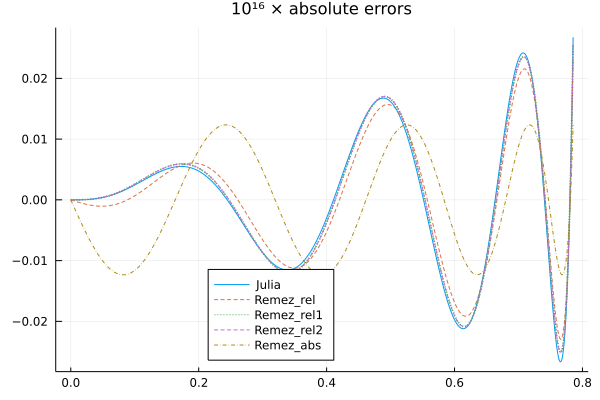

In [22]:
plot(; legend=:bottom)
plot!(; title="10¹⁶ × absolute errors", titlefontsize=11)
plot!(x, 10^16*error_julia; label="Julia", ls=:solid)
plot!(x, 10^16*error_Remez_rel;  label="Remez_rel", ls=:dash)
plot!(x, 10^16*error_Remez_rel1; label="Remez_rel1", ls=:dot, lw=1.8)
plot!(x, 10^16*error_Remez_rel1; label="Remez_rel2", ls=:dash)
plot!(x, 10^16*error_Remez_abs;  label="Remez_abs", ls=:dashdot)

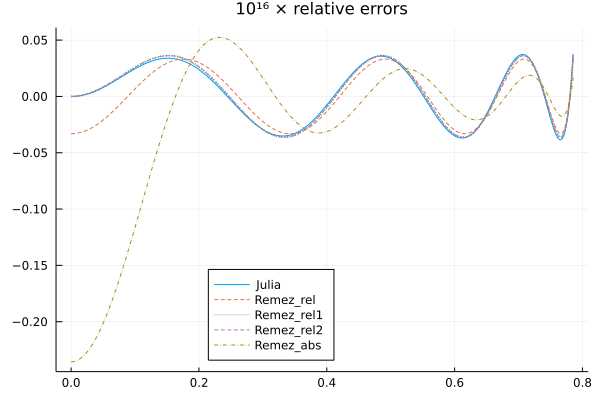

In [23]:
plot(; legend=:bottom)
plot!(; title="10¹⁶ × relative errors", titlefontsize=11)
plot!(x, 10^16*relerror_julia; label="Julia", ls=:solid)
plot!(x, 10^16*relerror_Remez_rel;  label="Remez_rel", ls=:dash)
plot!(x, 10^16*relerror_Remez_rel1; label="Remez_rel1", ls=:dot, lw=1.8)
plot!(x, 10^16*relerror_Remez_rel1; label="Remez_rel2", ls=:dash)
plot!(x, 10^16*relerror_Remez_abs;  label="Remez_abs", ls=:dashdot)

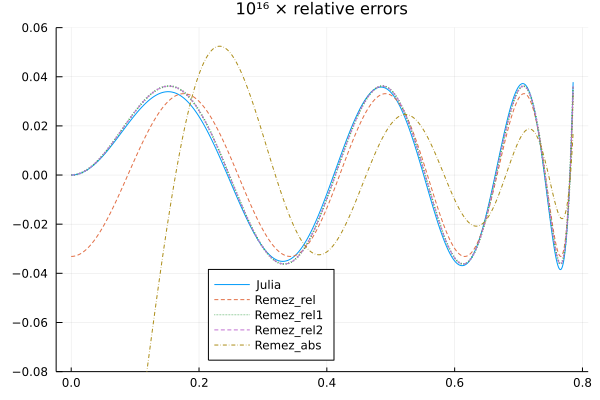

In [24]:
plot(; legend=:bottom)
plot!(; title="10¹⁶ × relative errors", titlefontsize=11)
plot!(x, 10^16*relerror_julia; label="Julia", ls=:solid)
plot!(x, 10^16*relerror_Remez_rel;  label="Remez_rel",  ls=:dash)
plot!(x, 10^16*relerror_Remez_rel1; label="Remez_rel1", ls=:dot, lw=1.8)
plot!(x, 10^16*relerror_Remez_rel1; label="Remez_rel2", ls=:dash)
plot!(x, 10^16*relerror_Remez_abs;  label="Remez_abs",  ls=:dashdot)
plot!(; ylim=(-0.08, 0.06))

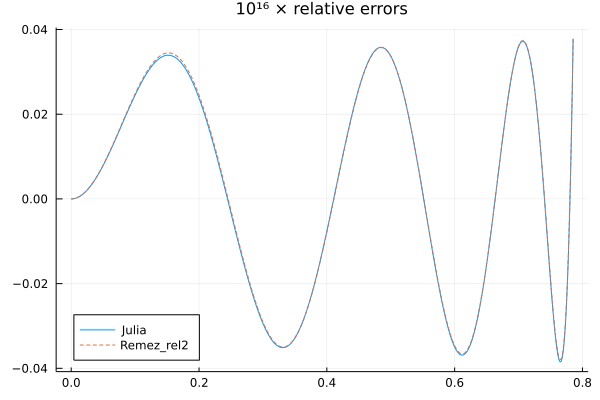

In [25]:
plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors", titlefontsize=11)
plot!(x, 10^16*relerror_julia; label="Julia", ls=:solid)
plot!(x, 10^16*relerror_Remez_rel2; label="Remez_rel2", ls=:dash)

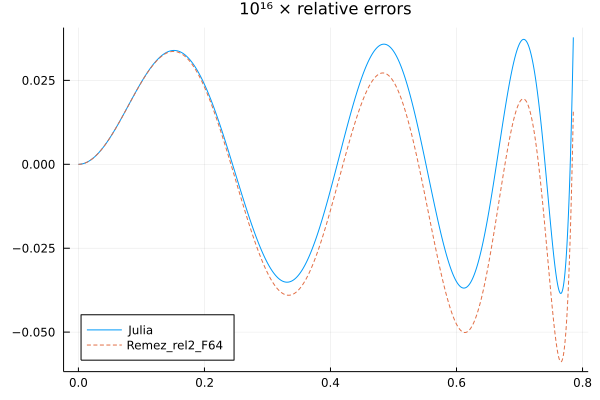

In [26]:
sin_Remez_rel2_F64 = convert(Polynomial{Float64}, sin_Remez_rel2)
sin_julia_F64 = Polynomial([0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6])

x = range(eps(Float128), π/4; length=1000)
y_Remez_rel2_F64 = sin_Remez_rel2_F64.(x)
y_julia_F64 = sin_julia_F64.(x)

relerror_Remez_rel2_F64 = relerr.(y_Remez_rel2_F64, y) .|> Float64
relerror_julia_F64 = relerr.(y_julia_F64, y) .|> Float64

plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors", titlefontsize=11)
plot!(x, 10^16*relerror_julia_F64; label="Julia", ls=:solid)
plot!(x, 10^16*relerror_Remez_rel2_F64; label="Remez_rel2_F64", ls=:dash)

## 低次の係数からFloat64での値に順次固定して求めてみる

### weight 1/x (minimaximize the pseudo relative error)

In [27]:
a1 = big"1.0"

1.0

In [28]:
r(x) = √abs(x)
F(x) = iszero(x) ? -1/typeof(x)(6) : (sin(x) - x*a1)/x^3
f(x) = F(r(x))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, (x,y)->abs(x))
sleep(0.1)

c3 = Float64.(N)
@show a3 = c3[1]
c3

  0.716019 seconds (2.34 M allocations: 150.800 MiB, 5.98% gc time, 89.51% compilation time)
a3 = c3[1] = -0.16666666666666632


6-element Vector{Float64}:
 -0.16666666666666632
  0.008333333333322425
 -0.00019841269829816953
  2.7557313695226773e-6
 -2.5050758653292795e-8
  1.5896827929447055e-10

In [29]:
F(x) = iszero(x) ? 1/big(120) : (sin(x) - x*(a1 + x^2*a3))/x^5
f(x) = F(r(x))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 4, 0, (x,y)->abs(x)^2)
sleep(0.1)

c5 = Float64.(N)
@show a5 = c5[1]
c5

  0.698706 seconds (2.46 M allocations: 156.183 MiB, 5.18% gc time, 83.39% compilation time)
a5 = c5[1] = 0.00833333333332249


5-element Vector{Float64}:
  0.00833333333332249
 -0.00019841269829858104
  2.755731370713369e-6
 -2.5050760264516078e-8
  1.5896910646738957e-10

In [30]:
F(x) = iszero(x) ? -1/factorial(big(7)) : (sin(x) - x*(a1 + x^2*(a3 + x^2*a5)))/x^7
f(x) = F(r(x))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 3, 0, (x,y)->abs(x)^3)
sleep(0.1)

c7 = Float64.(N)
@show a7 = c7[1]
c7

  0.734207 seconds (2.40 M allocations: 153.818 MiB, 4.46% gc time, 84.07% compilation time)
a7 = c7[1] = -0.00019841269829857798


4-element Vector{Float64}:
 -0.00019841269829857798
  2.7557313707000463e-6
 -2.5050760240351574e-8
  1.5896909089745573e-10

In [31]:
F(x) = iszero(x) ? 1/factorial(big(9)) : (sin(x) - x*(a1 + x^2*(a3 + x^2*(a5 + x^2*a7))))/x^9
f(x) = F(r(x))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 2, 0, (x,y)->abs(x)^4)
sleep(0.1)

c9 = Float64.(N)
@show a9 = c9[1]
c9

  0.773260 seconds (2.66 M allocations: 167.232 MiB, 4.66% gc time, 79.65% compilation time)
a9 = c9[1] = 2.755731370699997e-6


3-element Vector{Float64}:
  2.755731370699997e-6
 -2.5050760240238105e-8
  1.589690908128682e-10

In [32]:
F(x) = iszero(x) ? 1/factorial(big(11)) : (sin(x) - x*(a1 + x^2*(a3 + x^2*(a5 + x^2*(a7 + x^2*a9)))))/x^11
f(x) = F(r(x))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 1, 0, (x,y)->abs(x)^5)
sleep(0.1)

c11 = Float64.(N)
@show a11 = c11[1]
c11

  0.800284 seconds (2.61 M allocations: 164.274 MiB, 4.85% gc time, 78.37% compilation time)
a11 = c11[1] = -2.5050760240238542e-8


2-element Vector{Float64}:
 -2.5050760240238542e-8
  1.58969090813394e-10

In [33]:
F(x) = iszero(x) ? 1/factorial(big(13)) : 
    (sin(x) - x*(a1 + x^2*(a3 + x^2*(a5 + x^2*(a7 + x^2*(a9 + x^2*a11))))))/x^13
f(x) = F(r(x))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 0, 0, (x,y)->abs(x)^6)
sleep(0.1)

c13 = Float64.(N)
@show a13 = c13[1]
c13

  0.680973 seconds (2.18 M allocations: 141.483 MiB, 3.47% gc time, 88.46% compilation time)
a13 = c13[1] = 1.5896909081339358e-10


1-element Vector{Float64}:
 1.5896909081339358e-10

In [34]:
a = Float64[0.0, a1, 0.0, a3, 0.0, a5, 0.0, a7, 0.0, a9, 0.0, a11, 0.0, a13]
a[begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.00833333333332249
 -0.00019841269829857798
  2.755731370699997e-6
 -2.5050760240238542e-8
  1.5896909081339358e-10

In [35]:
a_julia = [0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6]
a_julia[begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.00833333333332249
 -0.0001984126982985795
  2.7557313707070068e-6
 -2.5050760253406863e-8
  1.58969099521155e-10

In [36]:
(a - a_julia)[begin+1:2:end]

7-element Vector{Float64}:
  0.0
  0.0
  0.0
  1.5178830414797062e-18
 -7.009621155002962e-18
  1.3168321613872625e-17
 -8.70776143101627e-18

extrema(relerror_a) = (-3.807933448320575e-18, 3.8242046100536915e-18)
extrema(relerror_j) = (-3.8479674641003996e-18, 3.782293158158398e-18)
extrema(relerror_aj) = (0.0, 4.1911451895294164e-20)


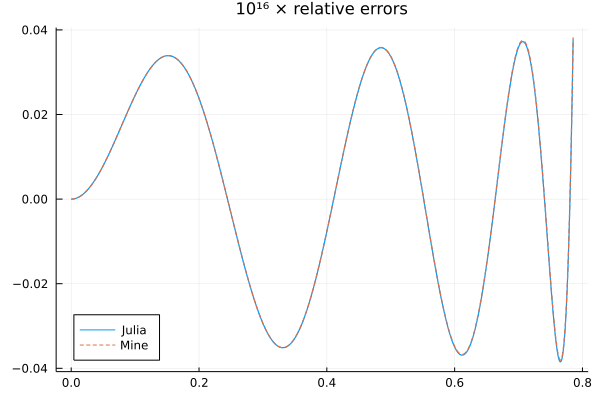

In [37]:
sin_a = Polynomial(a)
sin_j = Polynomial(a_julia)

x = range(eps(Float128), Float128(π)/4; length=1000)
y_a  = sin_a.(x)
y_j  = sin_j.(x)
y = sin.(x)

relerror_a = relerr.(y_a, y) .|> Float64
relerror_j = relerr.(y_j, y) .|> Float64
relerror_aj = relerr.(y_a, y_j) .|> Float64

@show extrema(relerror_a)
@show extrema(relerror_j)
@show extrema(relerror_aj)

plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors", titlefontsize=11)
plot!(x, 10^16*relerror_j; label="Julia", ls=:solid, lw=1.2)
plot!(x, 10^16*relerror_a; label="Mine",  ls=:dash, lw=1.2)

extrema(relerror_a) = (-1.4214147756120058e-16, 1.4789984539500598e-16)
extrema(relerror_j) = (-1.4214147756120058e-16, 1.4789984539500598e-16)
extrema(relerror_aj) = (0.0, 1.1923017141954185e-16)


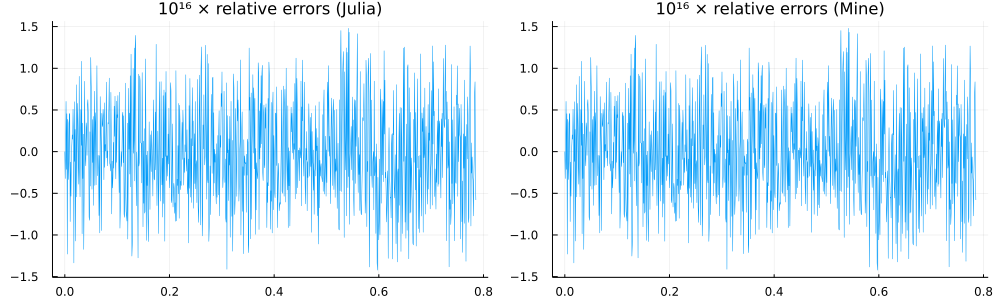

In [38]:
sin_a = Polynomial(a)
sin_j = Polynomial(a_julia)

x = range(eps(), π/4; length=1000)
y_a  = sin_a.(x)
y_j  = sin_j.(x)
y = sin.(Float128.(x))

relerror_a = relerr.(y_a, y) .|> Float64
relerror_j = relerr.(y_j, y) .|> Float64
relerror_aj = relerr.(y_a, y_j) .|> Float64

@show extrema(relerror_a)
@show extrema(relerror_j)
@show extrema(relerror_aj)

P = plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors (Julia)", titlefontsize=11)
plot!(x, 10^16*relerror_j; label="", lw=0.5)

Q = plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors (Mine)", titlefontsize=11)
plot!(x, 10^16*relerror_a; label="", lw=0.5)

plot(P, Q; size=(1000, 300))

### weight 1/sin(x) (minimaximize the exact relative error)

In [39]:
a1 = big"1.0"

1.0

In [40]:
r(x) = √abs(x)
F(x) = iszero(x) ? -1/typeof(x)(6) : (sin(x) - x*a1)/x^3
f(x) = F(r(x))
W(x, y) = iszero(x) ? x : x^3/sin(x)
w(x, y) = W(r(x), y)

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, w)
sleep(0.1)

@show N
c3 = Float64.(N)
@show a3 = c3[1]
c3

  0.165837 seconds (785.13 k allocations: 41.846 MiB, 5.54% gc time, 5.87% compilation time)
N = BigFloat[-0.1666666666666663072952319424706556423156268569311730452423500090679596766342067, 0.008333333333322118588620767348655291933598892159886572121418685685909876900639562, -0.000198412698295895384658205433413002384561693409854215006348978342855327765995882, 2.755731362138567735490131111468619433925539630687025389592380999080497633242137e-06, -2.505074776285035401346429694718708093864228380871557434024398068459375380021125e-08, 1.589623015722184479522046925205159987631971690111394108333898885040739878927266e-10]
a3 = c3[1] = -0.1666666666666663


6-element Vector{Float64}:
 -0.1666666666666663
  0.008333333333322118
 -0.0001984126982958954
  2.7557313621385676e-6
 -2.5050747762850355e-8
  1.5896230157221844e-10

In [41]:
F(x) = iszero(x) ? -1/typeof(x)(6) : (sin(x) - x*(a1 + x^2*a3))/x^5
f(x) = F(r(x))
W(x, y) = iszero(x) ? x : x^5/sin(x)
w(x, y) = W(r(x), y)

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 4, 0, w)
sleep(0.1)

c5 = Float64.(N)
@show a5 = c5[1]
c5

  0.185242 seconds (872.71 k allocations: 46.507 MiB, 6.60% gc time, 3.93% compilation time)
a5 = c5[1] = 0.00833333333332184


5-element Vector{Float64}:
  0.00833333333332184
 -0.00019841269829359222
  2.7557313538813368e-6
 -2.5050734442919327e-8
  1.5895436711807838e-10

In [42]:
F(x) = iszero(x) ? -1/factorial(big(7)) : (sin(x) - x*(a1 + x^2*(a3 + x^2*a5)))/x^7
f(x) = F(r(x))
W(x, y) = iszero(x) ? x : x^7/sin(x)
w(x, y) = W(r(x), y)

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 3, 0, w)
sleep(0.1)

c7 = Float64.(N)
@show a7 = c7[1]
c7

  0.224960 seconds (1.07 M allocations: 56.993 MiB, 4.27% gc time, 3.53% compilation time)
a7 = c7[1] = -0.00019841269829358528


4-element Vector{Float64}:
 -0.00019841269829358528
  2.7557313538513933e-6
 -2.505073438916828e-8
  1.5895433281027082e-10

In [43]:
F(x) = iszero(x) ? 1/factorial(big(9)) : (sin(x) - x*(a1 + x^2*(a3 + x^2*(a5 + x^2*a7))))/x^9
f(x) = F(r(x))
W(x, y) = iszero(x) ? x : x^9/sin(x)
w(x, y) = W(r(x), y)

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 2, 0, w)
sleep(0.1)

c9 = Float64.(N)
@show a9 = c9[1]
c9

  0.234002 seconds (1.07 M allocations: 57.183 MiB, 3.42% gc time, 3.41% compilation time)
a9 = c9[1] = 2.7557313538514234e-6


3-element Vector{Float64}:
  2.7557313538514234e-6
 -2.5050734389256567e-8
  1.5895433289228513e-10

In [44]:
F(x) = iszero(x) ? 1/factorial(big(9)) : (sin(x) - x*(a1 + x^2*(a3 + x^2*(a5 + x^2*(a7 + x^2*a9)))))/x^11
f(x) = F(r(x))
W(x, y) = iszero(x) ? x : x^11/sin(x)
w(x, y) = W(r(x), y)

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 1, 0, w)
sleep(0.1)

c11 = Float64.(N)
@show a11 = c11[1]
c11

  0.231021 seconds (975.63 k allocations: 51.918 MiB, 4.01% gc time, 5.15% compilation time)
a11 = c11[1] = -2.5050734389257543e-8


2-element Vector{Float64}:
 -2.5050734389257543e-8
  1.589543328934503e-10

In [45]:
F(x) = iszero(x) ? 1/factorial(big(9)) : 
    (sin(x) - x*(a1 + x^2*(a3 + x^2*(a5 + x^2*(a7 + x^2*(a9 + x^2*a11))))))/x^13
f(x) = F(r(x))
W(x, y) = iszero(x) ? x : x^13/sin(x)
w(x, y) = W(r(x), y)

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 0, 0, w)
sleep(0.1)

c13 = Float64.(N)
@show a13 = c13[1]
c13

  0.181294 seconds (834.50 k allocations: 44.401 MiB, 4.27% gc time, 5.08% compilation time)
a13 = c13[1] = 1.5895433289345187e-10


1-element Vector{Float64}:
 1.5895433289345187e-10

In [46]:
b = Float64[0.0, a1, 0.0, a3, 0.0, a5, 0.0, a7, 0.0, a9, 0.0, a11, 0.0, a13]
b[begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.1666666666666663
  0.00833333333332184
 -0.00019841269829358528
  2.7557313538514234e-6
 -2.5050734389257543e-8
  1.5895433289345187e-10

extrema(relerror_a) = (-3.807933448320575e-18, 3.8242046100536915e-18)
extrema(relerror_b) = (-3.747854098779666e-18, 3.747852189211488e-18)
extrema(relerror_j) = (-3.8479674641003996e-18, 3.782293158158398e-18)
extrema(relerror_aj) = (0.0, 4.1911451895294164e-20)
extrema(relerror_bj) = (-1.6953740591014053e-18, 5.422540431461975e-19)


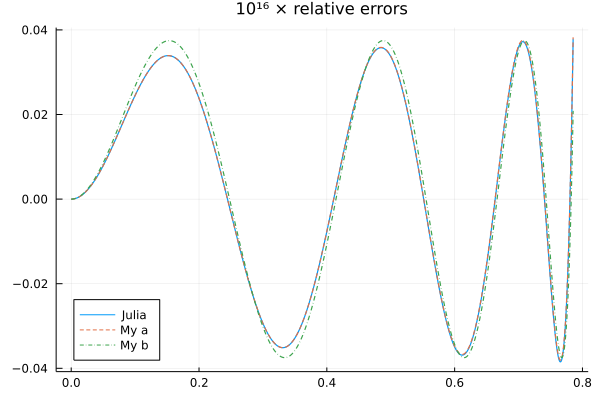

In [47]:
sin_b = Polynomial(b)

x = range(eps(Float128), Float128(π)/4; length=1000)
y_a  = sin_a.(x)
y_b  = sin_b.(x)
y_j  = sin_j.(x)
y = sin.(x)

relerror_a = relerr.(y_a, y) .|> Float64
relerror_b = relerr.(y_b, y) .|> Float64
relerror_j = relerr.(y_j, y) .|> Float64
relerror_aj = relerr.(y_a, y_j) .|> Float64
relerror_bj = relerr.(y_b, y_j) .|> Float64

@show extrema(relerror_a)
@show extrema(relerror_b)
@show extrema(relerror_j)
@show extrema(relerror_aj)
@show extrema(relerror_bj)

plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors", titlefontsize=11)
plot!(x, 10^16*relerror_j; label="Julia", ls=:solid, lw=1.2)
plot!(x, 10^16*relerror_a; label="My a",  ls=:dash, lw=1.2)
plot!(x, 10^16*relerror_b; label="My b",  ls=:dashdot, lw=1.2)

extrema(relerror_a) = (-1.4214147756120058e-16, 1.4789984539500598e-16)
extrema(relerror_b) = (-1.4214147756120058e-16, 1.4789984539500598e-16)
extrema(relerror_j) = (-1.4214147756120058e-16, 1.4789984539500598e-16)
extrema(relerror_aj) = (0.0, 1.1923017141954185e-16)
extrema(relerror_bj) = (0.0, 1.1923017141954185e-16)


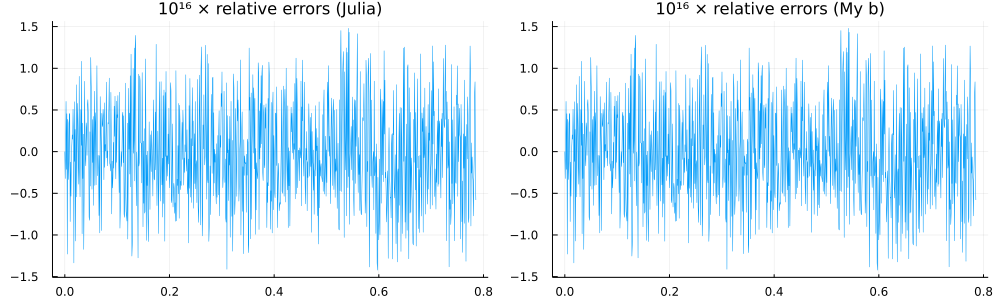

In [48]:
sin_a = Polynomial(a)
sin_b = Polynomial(b)
sin_j = Polynomial(a_julia)

x = range(eps(), π/4; length=1000)
y_a  = sin_a.(x)
y_b  = sin_b.(x)
y_j  = sin_j.(x)
y = sin.(Float128.(x))

relerror_a = relerr.(y_a, y) .|> Float64
relerror_b = relerr.(y_b, y) .|> Float64
relerror_j = relerr.(y_j, y) .|> Float64
relerror_aj = relerr.(y_a, y_j) .|> Float64
relerror_bj = relerr.(y_b, y_j) .|> Float64

@show extrema(relerror_a)
@show extrema(relerror_b)
@show extrema(relerror_j)
@show extrema(relerror_aj)
@show extrema(relerror_bj)

P = plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors (Julia)", titlefontsize=11)
plot!(x, 10^16*relerror_j; label="", lw=0.5)

Q = plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors (My b)", titlefontsize=11)
plot!(x, 10^16*relerror_b; label="", lw=0.5)

plot(P, Q; size=(1000, 300))

## 以下は汚い試行錯誤の残骸

In [49]:
r(x) = √abs(x)
f(x) = iszero(x) ? -1/big(6) : (sin(r(x)) - r(x))/r(x)^3
w_f(x, y) = iszero(x) ? x : abs(r(x)^3/sin(r(x)))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, w_f)
sleep(0.1)

c = eltype(N3)[0; 1; 0; [isodd(k) ? N[(k+1)÷2] : 0 for k in 1:11]]
c = Float128.(c)
c[begin+1:2:end] |> display
sin_Remez_rel1′ = Polynomial(c)

7-element Vector{Float128}:
  1.00000000000000000000000000000000000e+00
 -1.66666666666666307295231942470655646e-01
  8.33333333332211858862076734865529242e-03
 -1.98412698295895384658205433413002396e-04
  2.75573136213856773549013111146861934e-06
 -2.50507477628503540134642969471870803e-08
  1.58962301572218447952204692520516006e-10

  0.195141 seconds (919.59 k allocations: 49.012 MiB, 10.88% gc time)


Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666307295231942470655646e-01*x^3 + 8.33333333332211858862076734865529242e-03*x^5 - 1.98412698295895384658205433413002396e-04*x^7 + 2.75573136213856773549013111146861934e-06*x^9 - 2.50507477628503540134642969471870803e-08*x^11 + 1.58962301572218447952204692520516006e-10*x^13)

In [50]:
sin_Remez_rel1′ - sin_Remez_rel1

Polynomial(0.00000000000000000000000000000000000e+00)

In [51]:
r(x) = √abs(x)
f(x) = iszero(x) ? -1/big(6) : (sin(r(x)) - r(x))/r(x)^3
w_f(x, y) = iszero(x) ? x : abs(r(x)^3/sin(r(x)))

@time N, D, E, X = ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, (x,y)->abs(x))
sleep(0.1)

c = eltype(N)[0; 1; 0; [isodd(k) ? N[(k+1)÷2] : 0 for k in 1:11]]
c = Float128.(c)
c[begin+1:2:end] |> display
sin_Remez_rel2′ = Polynomial(c)

7-element Vector{Float128}:
  1.00000000000000000000000000000000000e+00
 -1.66666666666666320682100284734673128e-01
  8.33333333332242453061710164240838880e-03
 -1.98412698298169519982088571757731898e-04
  2.75573136952267715796435540350079496e-06
 -2.50507586532927947765459874988117069e-08
  1.58968279294470556731220197278242257e-10

  0.686317 seconds (2.32 M allocations: 148.873 MiB, 4.59% gc time, 88.89% compilation time)


Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666320682100284734673128e-01*x^3 + 8.33333333332242453061710164240838880e-03*x^5 - 1.98412698298169519982088571757731898e-04*x^7 + 2.75573136952267715796435540350079496e-06*x^9 - 2.50507586532927947765459874988117069e-08*x^11 + 1.58968279294470556731220197278242257e-10*x^13)

In [52]:
sin_Remez_rel2′ - sin_Remez_rel2

Polynomial(2.86985925493722536125179818657774824e-42*x^11)

In [53]:
using Remez: ratfn_leastsquares, ratfn_eval, find_extrema, winnow_extrema, ratfn_equal_deviation

function my_ratfn_minimax(f, interval, n, d,
                       w = (x,y)->BigFloat(1);
        epsbits = precision(BigFloat),
        threshold = 2^(-epsbits/3)
    )
    # We start off by finding a least-squares approximation. This
    # doesn't need to be perfect, but if we can get it reasonably good
    # then it'll save iterations in the refining stage.
    #
    # Least-squares approximations tend to look nicer in a minimax
    # sense if you evaluate the function at a big pile of Chebyshev
    # nodes rather than uniformly spaced points. These values will
    # also make a good grid to use for the initial search for error
    # extrema, so we'll keep them around for that reason too.

    # Construct the grid.
    lo = BigFloat(minimum(interval))
    hi = BigFloat(maximum(interval))

    local grid
    let
        mid = (hi+lo)/2
        halfwid = (hi-lo)/2
        nnodes = 16 * (n+d+1)
        grid = [ mid - halfwid * cospi(big(i)/big(nnodes)) for i=0:nnodes ]
    end

    # Find the initial least-squares approximation.
    (nc, dc) = ratfn_leastsquares(f, grid, n, d, w)

    # Threshold of convergence. We stop when the relative difference
    # between the min and max (winnowed) error extrema is less than
    # this.
    #
    # This is set to the cube root of machine epsilon on a more or
    # less empirical basis, because the rational-function case will
    # not converge reliably if you set it to only the square root.
    # (Repeatable by using the --test mode.) On the assumption that
    # input and output error in each iteration can be expected to be
    # related by a simple power law (because it'll just be down to how
    # many leading terms of a Taylor series are zero), the cube root
    # was the next thing to try.
    #epsbits = precision(BigFloat)
    #threshold = 2^(-epsbits/3)

    # Main loop.
    maxiters = 10^3
    iter = 0
    max_err = zero(BigFloat)
    extrema = Vector{Tuple{BigFloat, BigFloat}}()
    while iter < maxiters
        iter += 1
        iszero(mod(iter, 100)) && print(iter, " ")
        # Find all the error extrema we can.
        function compute_error(x)
            real_y = f(x)
            approx_y = ratfn_eval(nc, dc, x)
            return (approx_y - real_y) * w(x, real_y)
        end
        extrema = find_extrema(compute_error, grid)

        # Winnow the extrema down to the right number, and ensure they
        # have alternating sign.
        extrema = winnow_extrema(extrema, n+d+2)

        # See if we've finished.
        min_err = minimum([abs(y) for (x,y) = extrema])
        max_err = maximum([abs(y) for (x,y) = extrema])
        variation = (max_err - min_err) / max_err
        if variation < threshold
            return nc, dc, max_err, extrema
        end

        # If not, refine our function by equalising the error at the
        # extrema points, and go round again.
        (nc, dc) = ratfn_equal_deviation(f, map(x->x[1], extrema),
                                         n, d, max_err, w)
    end
    
    println("maxiters = $maxiters")
    return nc, dc, max_err, extrema
end

my_ratfn_minimax (generic function with 2 methods)

In [54]:
r(x) = √abs(x)
f(x) = iszero(x) ? -1/big(6) : (sin(r(x)) - r(x))/r(x)^3
w_f(x, y) = iszero(x) ? x : abs(r(x)^3/sin(r(x)))

setprecision(80)

@time N, D, E, X = my_ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, w_f; 
    threshold = 2^(-precision(BigFloat)/7))
sleep(0.1)

c = eltype(N)[0; 1; 0; [isodd(k) ? N[(k+1)÷2] : 0 for k in 1:11]]
c[begin+1:2:end] |> display

sin_Remez = Polynomial(c)
sin_Remez |> display

setprecision(256);

7-element Vector{BigFloat}:
  1.0
 -0.16666666666666630729557283
  0.0083333333333221185956677847
 -0.00019841269829589542824643312
  2.7557313621386810577950061e-06
 -2.505074776298150096875241e-08
  1.589623016277735125564894e-10

Polynomial(1.0*x - 0.16666666666666630729557283*x^3 + 0.0083333333333221185956677847*x^5 - 0.00019841269829589542824643312*x^7 + 2.7557313621386810577950061e-06*x^9 - 2.505074776298150096875241e-08*x^11 + 1.589623016277735125564894e-10*x^13)

  0.024720 seconds (252.25 k allocations: 11.539 MiB)


In [55]:
r(x) = √abs(x)
f(x) = iszero(x) ? -1/big(6) : (sin(r(x)) - r(x))/r(x)^3
w_f(x, y) = iszero(x) ? x : abs(r(x)^3/sin(r(x)))

setprecision(64)

@time N, D, E, X = my_ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, w_f; 
    threshold = 2^(-precision(BigFloat)/7))
sleep(0.1)

c = eltype(N)[0; 1; 0; [isodd(k) ? N[(k+1)÷2] : 0 for k in 1:11]]
c[begin+1:2:end] |> display

sin_Remez = Polynomial(c)
sin_Remez |> display

setprecision(256);

7-element Vector{BigFloat}:
  1.0
 -0.166666666666666307204
  0.00833333333332211292799
 -0.000198412698295841567618
  2.75573136194849609589e-06
 -2.50507474760110422528e-08
  1.58962144835870768875e-10

Polynomial(1.0*x - 0.166666666666666307204*x^3 + 0.00833333333332211292799*x^5 - 0.000198412698295841567618*x^7 + 2.75573136194849609589e-06*x^9 - 2.50507474760110422528e-08*x^11 + 1.58962144835870768875e-10*x^13)

  0.187425 seconds (1.60 M allocations: 61.375 MiB, 8.14% gc time)


In [56]:
r(x) = √abs(x)
f(x) = iszero(x) ? -1/big(6) : (sin(r(x)) - r(x))/r(x)^3
w_f(x, y) = iszero(x) ? x : abs(r(x)^3/sin(r(x)))

setprecision(60)

@time N, D, E, X = my_ratfn_minimax(f, (big"0.0", (big(π)/4)^2), 5, 0, w_f; 
    threshold = 2^(-precision(BigFloat)/12))
sleep(0.1)

c = eltype(N)[0; 1; 0; [isodd(k) ? N[(k+1)÷2] : 0 for k in 1:11]]
c[begin+1:2:end] |> display
c[begin+1:2:end] .|> Float64 |> display

sin_Remez = Polynomial(c)
sin_Remez |> display

setprecision(256);

7-element Vector{BigFloat}:
  1.0
 -0.16666666666666631264
  0.0083333333333221824287
 -0.00019841269829612920956
  2.7557313624420290977e-06
 -2.505074780001512529e-08
  1.5896218050640936251e-10

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.008333333333322182
 -0.0001984126982961292
  2.755731362442029e-6
 -2.5050747800015127e-8
  1.5896218050640936e-10

Polynomial(1.0*x - 0.16666666666666631264*x^3 + 0.0083333333333221824287*x^5 - 0.00019841269829612920956*x^7 + 2.7557313624420290977e-06*x^9 - 2.505074780001512529e-08*x^11 + 1.5896218050640936251e-10*x^13)

  0.119860 seconds (1.08 M allocations: 41.549 MiB, 8.72% gc time)


In [57]:
[0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6][begin+1:2:end] |> display

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.00833333333332249
 -0.0001984126982985795
  2.7557313707070068e-6
 -2.5050760253406863e-8
  1.58969099521155e-10

7-element Vector{Float128}:
  9.99999999999999996856391788001735729e-01
 -1.66666666666666167074524683589252449e-01
  8.33333333332037033403990989155899782e-03
 -1.98412698286557484956047205804699700e-04
  2.75573133781035511845640470657025828e-06
 -2.50507172195637856232689274987341170e-08
  1.58947499158789619947224046893606705e-10

Polynomial(9.99999999999999996856391788001735729e-01*x - 1.66666666666666167074524683589252449e-01*x^3 + 8.33333333332037033403990989155899782e-03*x^5 - 1.98412698286557484956047205804699700e-04*x^7 + 2.75573133781035511845640470657025828e-06*x^9 - 2.50507172195637856232689274987341170e-08*x^11 + 1.58947499158789619947224046893606705e-10*x^13)

7-element Vector{Float128}:
  1.00000000000000000000000000000000000e+00
 -1.66666666666666320682100284734673128e-01
  8.33333333332242453061710164240838880e-03
 -1.98412698298169519982088571757731898e-04
  2.75573136952267715796435540350079459e-06
 -2.50507586532927947765459874988116869e-08
  1.58968279294470556731220197278284700e-10

Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666320682100284734673128e-01*x^3 + 8.33333333332242453061710164240838880e-03*x^5 - 1.98412698298169519982088571757731898e-04*x^7 + 2.75573136952267715796435540350079459e-06*x^9 - 2.50507586532927947765459874988116869e-08*x^11 + 1.58968279294470556731220197278284700e-10*x^13)

7-element Vector{Float128}:
  1.00000000000000000000000000000000000e+00
 -1.66666666666666320682100284734673128e-01
  8.33333333332242453061710164240838880e-03
 -1.98412698298169519982088571757731898e-04
  2.75573136952267715796435540350079496e-06
 -2.50507586532927947765459874988117098e-08
  1.58968279294470556731220197278242257e-10

Polynomial(1.00000000000000000000000000000000000e+00*x - 1.66666666666666320682100284734673128e-01*x^3 + 8.33333333332242453061710164240838880e-03*x^5 - 1.98412698298169519982088571757731898e-04*x^7 + 2.75573136952267715796435540350079496e-06*x^9 - 2.50507586532927947765459874988117098e-08*x^11 + 1.58968279294470556731220197278242257e-10*x^13)

  0.157397 seconds (1.42 M allocations: 74.807 MiB, 6.10% gc time)
  0.727221 seconds (3.10 M allocations: 189.899 MiB, 5.14% gc time, 75.22% compilation time)
  0.713008 seconds (3.11 M allocations: 190.883 MiB, 4.72% gc time, 75.61% compilation time)


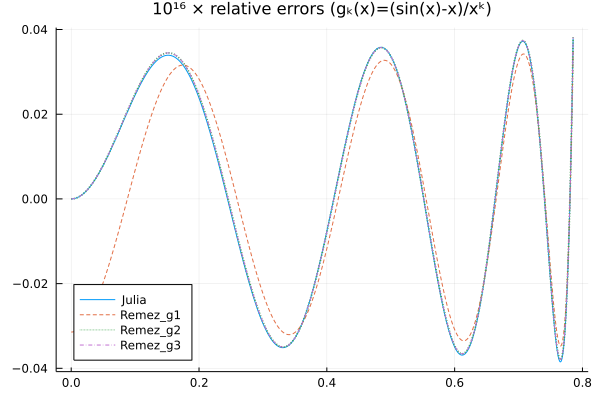

In [58]:
g1(x) = iszero(x) ? x : (sin(x) - x)/x
@time N, D, E, X = ratfn_minimax(g1, (-big(π)/4, big(π)/4), 12, 0)
sleep(0.1)
c = @. Float128(round(N; digits=50))
c = Float128[0; 1+c[1]; c[2:end]]
c[begin+1:2:end] |> display
sin_Remez_g1 = Polynomial(c)
sin_Remez_g1 |> display
y_g1 = sin_Remez_g1.(x)
relerror_Remez_g1 = relerr.(y_g1, y) .|> Float64

g2(x) = iszero(x) ? x : (sin(x) - x)/x^2
@time N, D, E, X = ratfn_minimax(g2, (-big(π)/4, big(π)/4), 11, 0, (x,y)->abs(x))
sleep(0.1)
c = @. Float128(round(N; digits=50))
c = Float128[0; 1; c]
c[begin+1:2:end] |> display
sin_Remez_g2 = Polynomial(c)
sin_Remez_g2 |> display
y_g2 = sin_Remez_g2.(x)
relerror_Remez_g2 = relerr.(y_g2, y) .|> Float64

g3(x) = iszero(x) ? -1/typeof(x)(6) : (sin(x) - x)/x^3
@time N, D, E, X = ratfn_minimax(g3, (-big(π)/4, big(π)/4), 10, 0, (x,y)->x^2)
sleep(0.1)
c = @. Float128(round(N; digits=50))
c = Float128[0; 1; 0; c]
c[begin+1:2:end] |> display
sin_Remez_g3 = Polynomial(c)
sin_Remez_g3 |> display
y_g3 = sin_Remez_g3.(x)
relerror_Remez_g3 = relerr.(y_g3, y) .|> Float64

plot(; legend=:bottomleft)
plot!(; title="10¹⁶ × relative errors (gₖ(x)=(sin(x)-x)/xᵏ)", titlefontsize=11)
plot!(x, 10^16*relerror_julia; label="Julia", ls=:solid)
plot!(x, 10^16*relerror_Remez_g1;  label="Remez_g1",  ls=:dash)
plot!(x, 10^16*relerror_Remez_g2;  label="Remez_g2",  ls=:dot, lw=1.8)
plot!(x, 10^16*relerror_Remez_g3;  label="Remez_g3",  ls=:dashdot)

In [59]:
cg2 = Float64.(coeffs(sin_Remez_g2))[begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.008333333333322425
 -0.00019841269829816953
  2.7557313695226773e-6
 -2.5050758653292795e-8
  1.5896827929447055e-10

In [60]:
cg3 = Float64.(coeffs(sin_Remez_g3))[begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.008333333333322425
 -0.00019841269829816953
  2.7557313695226773e-6
 -2.5050758653292795e-8
  1.5896827929447055e-10

In [61]:
cg2 == cg3

true

In [62]:
cjulia = [0.0, DS0, 0.0, DS1, 0.0, DS2, 0.0, DS3, 0.0, DS4, 0.0, DS5, 0.0, DS6][begin+1:2:end]

7-element Vector{Float64}:
  1.0
 -0.16666666666666632
  0.00833333333332249
 -0.0001984126982985795
  2.7557313707070068e-6
 -2.5050760253406863e-8
  1.58969099521155e-10

In [63]:
cg3 - cjulia

7-element Vector{Float64}:
  0.0
  0.0
 -6.418476861114186e-17
  4.0996394647108136e-16
 -1.1843295136639616e-15
  1.6001140687165051e-15
 -8.202266844605415e-16